## TUTORIAL 01 - Thermal block problem
**_Keywords: certified reduced basis method, scalar problem_**

### 1. Introduction
In this Tutorial, we consider steady heat conduction in a two-dimensional domain $\Omega$.

![mesh](data/mesh.png)

We define two subdomains $\Omega_1$ and $\Omega_2$, such that
1. $\Omega_1$ is a disk centered at the origin of radius $r_0=0.5$, and
2. $\Omega_2=\Omega/\ \overline{\Omega_1}$. 

The conductivity $\kappa$ is assumed to be constant on $\Omega_1$ and $\Omega_2$, i.e.
$$
\kappa|_{\Omega_1}=\kappa_0 \quad \textrm{and} \quad \kappa|_{\Omega_2}=1.
$$

For this problem, we consider $P=2$ parameters:
1. the first one is related to the conductivity in $\Omega_1$, i.e. $\mu_0\equiv k_0$ (_note that parameters numbering is zero-based_);
2. the second parameter $\mu_1$ takes into account the constant heat flux over $\Gamma_{base}$.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.1,10]\times[-1,1].
$$

In this problem we model the heat transfer process due to the heat flux over the bottom boundary $\Gamma_{base}$ and the following conditions on the remaining boundaries:
* the left and right boundaries $\Gamma_{side}$ are insulated,
* the top boundary $\Gamma_{top}$ is kept at a reference temperature (say, zero),

with the aim of measuring the average temperature on $\Gamma_{base}$.

In order to obtain a faster evaluation (yet, provably accurate) of the output of interest we propose to use a certified reduced basis approximation for the problem.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the temperature in the domain $\Omega$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$
\begin{cases}
	- \text{div} (\kappa(\mu_0)\nabla u(\boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
	u(\boldsymbol{\mu}) = 0 & \text{on } \Gamma_{top},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = 0 & \text{on } \Gamma_{side},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = \mu_1 & \text{on } \Gamma_{base}.
\end{cases}
$$
<br>

where 
* $\mathbf{n}$ denotes the outer normal to the boundaries $\Gamma_{side}$ and $\Gamma_{base}$,
* the conductivity $\kappa(\mu_0)$ is defined as follows:
$$
\kappa(\mu_0) =
\begin{cases}
	\mu_0 & \text{in } \Omega_1,\\
	1 & \text{in } \Omega_2,\\
\end{cases}
$$

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H^1(\Omega) : v|_{\Gamma_{top}}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \kappa(\mu_0)\nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \mu_1\int_{\Gamma_{base}}v \ ds.$$

The (compliant) output of interest $s(\boldsymbol{\mu})$ given by
$$s(\boldsymbol{\mu}) = \mu_1\int_{\Gamma_{base}} u(\boldsymbol{\mu})$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega_1}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega_2}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_1(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{\mu_1}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{base}}v \ ds}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class ThermalBlock(EllipticCoerciveCompliantProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
class ThermalBlock(EllipticCoerciveCompliantProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveCompliantProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)

    # Return custom problem name
    def name(self):
        return "ThermalBlock"

    # Return the alpha_lower bound.
    def get_stability_factor_lower_bound(self):
        return min(self.compute_theta("a"))

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = 1.
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = mu[1]
            return (theta_f0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx(1)
            a1 = inner(grad(u), grad(v)) * dx(2)
            return (a0, a1)
        elif term == "f":
            ds = self.ds
            f0 = v * ds(1)
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/thermal_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/thermal_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/thermal_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the ThermalBlock class

In [5]:
problem = ThermalBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(1e-10)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(10)
reduced_problem = reduction_method.offline()

#### 4.5.2 Train PINN

Given a training set $\Xi_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(N_\text{PINN})})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $u^{NN}(\boldsymbol{\mu})$ for the reduced order equations dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(\Xi_{PINN}; W) = \frac{1}{N_\text{PINN}} \sum_{i=1}^{N_\text{PINN}} \|A(\boldsymbol{\mu^{(i)}}) u^{NN}(\boldsymbol{\mu}^{(i)}; W) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)})\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled reduced matrix corresponding to the bilinear form $a$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled reduced vector corresponding to the linear form $f$.

In [8]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [9]:
pinn_trainer.train()

10000 	Loss(training) = 5.4794326622445986e-05 	Loss(validation) = 6.443431740469647e-05
10100 	Loss(training) = 5.4216039922934564e-05 	Loss(validation) = 6.078997880087149e-05
10200 	Loss(training) = 5.1534215853810884e-05 	Loss(validation) = 5.8889730062787125e-05
10300 	Loss(training) = 4.9917673624041994e-05 	Loss(validation) = 5.606863729996749e-05
10400 	Loss(training) = 4.8520323137900365e-05 	Loss(validation) = 5.444015933199699e-05
10500 	Loss(training) = 4.710224095130674e-05 	Loss(validation) = 5.1348122254495044e-05
10600 	Loss(training) = 4.571522170512409e-05 	Loss(validation) = 4.901903527413802e-05
10700 	Loss(training) = 4.703460877531416e-05 	Loss(validation) = 4.767524093527198e-05
10800 	Loss(training) = 4.327591883043203e-05 	Loss(validation) = 4.544416225707416e-05
10900 	Loss(training) = 4.212812565386684e-05 	Loss(validation) = 4.341698933641207e-05
11000 	Loss(training) = 4.133217356533324e-05 	Loss(validation) = 4.221039918763294e-05
11100 	Loss(training) = 4

19300 	Loss(training) = 2.9282220900180206e-05 	Loss(validation) = 3.2268070970495624e-05
19400 	Loss(training) = 6.6181806991239234e-06 	Loss(validation) = 2.850683628428121e-05
19500 	Loss(training) = 6.465600490160573e-06 	Loss(validation) = 2.8314098496414353e-05
19600 	Loss(training) = 7.445880365005854e-06 	Loss(validation) = 3.1838854952158584e-05
19700 	Loss(training) = 6.189940690734573e-06 	Loss(validation) = 2.8291664411869635e-05
19800 	Loss(training) = 6.061915240837311e-06 	Loss(validation) = 2.825234388300128e-05
19900 	Loss(training) = 5.9607749298924015e-06 	Loss(validation) = 2.839006937992815e-05


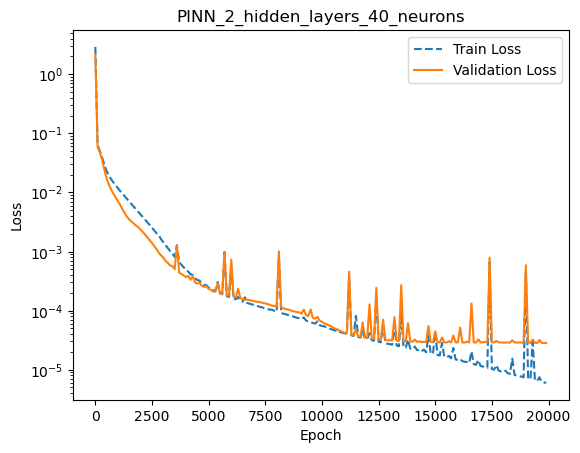

In [10]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $\Xi_{PDNN} = ((\boldsymbol{\mu}^{(1)}, u^{\text{HF}}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(N_\text{PDNN})}, u^{\text{HF}}(\boldsymbol{\mu}^{(N_\text{PDNN})})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(\Xi_{PDNN}; W) = \frac{1}{N_\text{PDNN}} \sum_{i=1}^{N_\text{PDNN}} \|u^{NN}(\boldsymbol{\mu}^{(i)}; W) - U^T u^{\text{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, the quantity $U^T u^{\text{HF}}(\boldsymbol{\mu})$ is the projection of the high fidelity solution $u^{\text{HF}}(\boldsymbol{\mu})$ onto the reduced order space.

In [11]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=3000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [12]:
pdnn_trainer.train()

3000 	Loss(training) = 2.664340585785088e-13 	Loss(validation) = 0.015821506313359913
3100 	Loss(training) = 1.2933009057422853e-13 	Loss(validation) = 0.01582145447543261
3200 	Loss(training) = 7.267749012837651e-14 	Loss(validation) = 0.015821403688011413
3300 	Loss(training) = 5.966837413967074e-14 	Loss(validation) = 0.015821380170117028
3400 	Loss(training) = 3.404153788195207e-14 	Loss(validation) = 0.01582134779002857
3500 	Loss(training) = 4.783475366731022e-14 	Loss(validation) = 0.01582135452763571
3600 	Loss(training) = 9.26757231546306e-13 	Loss(validation) = 0.015821263272421185
3700 	Loss(training) = 2.2105137342060314e-09 	Loss(validation) = 0.01581554104725929
3800 	Loss(training) = 1.288036703636476e-09 	Loss(validation) = 0.015814376581241144
3900 	Loss(training) = 2.075969905723068e-06 	Loss(validation) = 0.01563503164513394
4000 	Loss(training) = 1.4928638518060175e-09 	Loss(validation) = 0.01581300713302283
4100 	Loss(training) = 7.354333206395827e-14 	Loss(validat

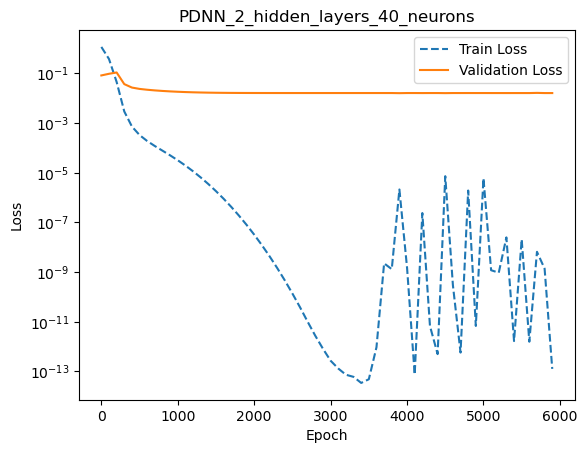

In [13]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(\Xi_{PINN}, \Xi_{PDNN}; W) = L_{PINN}(\Xi_{PINN}; W) + \omega L_{PDNN}(\Xi_{PDNN}; W)$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [14]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=40000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [15]:
prnn_trainer.train()

37900 	Loss(training) = 1.3432163244791812e-05 	Loss(validation) = 0.011384628258346503
38000 	Loss(training) = 0.00038337831304912897 	Loss(validation) = 0.012256304150914865
38100 	Loss(training) = 1.335892898731804e-05 	Loss(validation) = 0.0113933643042127
38200 	Loss(training) = 1.3310365697375952e-05 	Loss(validation) = 0.011383086632912135
38300 	Loss(training) = 1.5009303815972514e-05 	Loss(validation) = 0.011453378697906053
38400 	Loss(training) = 1.3240026962465994e-05 	Loss(validation) = 0.01139644033322415
38500 	Loss(training) = 1.3530193653274019e-05 	Loss(validation) = 0.01136095863436207
38600 	Loss(training) = 1.5597334941009867e-05 	Loss(validation) = 0.011590131444085812
38700 	Loss(training) = 1.3115897255430227e-05 	Loss(validation) = 0.011389503875863044
38800 	Loss(training) = 1.3995178771837066e-05 	Loss(validation) = 0.01142286346497549
38900 	Loss(training) = 1.3041621544910349e-05 	Loss(validation) = 0.01139277999604657
39000 	Loss(training) = 3.2518264876325

47300 	Loss(training) = 1.0995678858727091e-05 	Loss(validation) = 0.01148643217699825
47400 	Loss(training) = 1.0432132108360504e-05 	Loss(validation) = 0.011535914198582615
47500 	Loss(training) = 1.0382663187269581e-05 	Loss(validation) = 0.011545713727218554
47600 	Loss(training) = 1.155127826374825e-05 	Loss(validation) = 0.01149317502824089
47700 	Loss(training) = 1.0332804083330617e-05 	Loss(validation) = 0.011550232053156768
47800 	Loss(training) = 1.3081122744560759e-05 	Loss(validation) = 0.011469641031809677
47900 	Loss(training) = 1.0285993694443442e-05 	Loss(validation) = 0.01155658282930519
48000 	Loss(training) = 1.1305015224643272e-05 	Loss(validation) = 0.011486555491384894
48100 	Loss(training) = 1.0247605662890568e-05 	Loss(validation) = 0.01155732583962166
48200 	Loss(training) = 1.0211643422436552e-05 	Loss(validation) = 0.011562748180541867
48300 	Loss(training) = 1.0308686670343796e-05 	Loss(validation) = 0.011545189752908783
48400 	Loss(training) = 1.05434768250

56800 	Loss(training) = 8.45487597103242e-06 	Loss(validation) = 0.011763855333357661
56900 	Loss(training) = 2.7687466075848042e-05 	Loss(validation) = 0.01178519711814963
57000 	Loss(training) = 8.421313261632224e-06 	Loss(validation) = 0.011766156251977475
57100 	Loss(training) = 0.0001219428506554289 	Loss(validation) = 0.012490775996303998
57200 	Loss(training) = 8.400955392352104e-06 	Loss(validation) = 0.01177510071456614
57300 	Loss(training) = 8.369583729188027e-06 	Loss(validation) = 0.01176957504372353
57400 	Loss(training) = 1.0112501446654522e-05 	Loss(validation) = 0.011752810382193097
57500 	Loss(training) = 1.0442124840204568e-05 	Loss(validation) = 0.011837732875174216
57600 	Loss(training) = 8.735021649025565e-06 	Loss(validation) = 0.011742479111616385
57700 	Loss(training) = 8.352927107224843e-06 	Loss(validation) = 0.011790583403854742
57800 	Loss(training) = 8.636057955615211e-06 	Loss(validation) = 0.011809101982029037
57900 	Loss(training) = 8.285207588904494e-0

66300 	Loss(training) = 7.045510136772898e-06 	Loss(validation) = 0.011926126298056696
66400 	Loss(training) = 7.0249799374818584e-06 	Loss(validation) = 0.011923991863840647
66500 	Loss(training) = 7.15416864332452e-06 	Loss(validation) = 0.011908016944118976
66600 	Loss(training) = 7.000320609134106e-06 	Loss(validation) = 0.01192742813373714
66700 	Loss(training) = 3.32712776831233e-05 	Loss(validation) = 0.011874619032394172
66800 	Loss(training) = 2.4754823109047288e-05 	Loss(validation) = 0.012137454758829191
66900 	Loss(training) = 4.3018133283082935e-05 	Loss(validation) = 0.011587843755646607
67000 	Loss(training) = 6.955202996835586e-06 	Loss(validation) = 0.011935136270431808
67100 	Loss(training) = 6.9897876074011785e-06 	Loss(validation) = 0.011972355008252975
67200 	Loss(training) = 1.9657768951266578e-05 	Loss(validation) = 0.012151025567439624
67300 	Loss(training) = 6.910985052718498e-06 	Loss(validation) = 0.011930375679674773
67400 	Loss(training) = 7.533090318829634

75800 	Loss(training) = 6.340936364072977e-06 	Loss(validation) = 0.01193402838284198
75900 	Loss(training) = 1.233555692903631e-05 	Loss(validation) = 0.012144308292612548
76000 	Loss(training) = 5.911078179533332e-06 	Loss(validation) = 0.011956625511163135
76100 	Loss(training) = 6.1007165452920765e-06 	Loss(validation) = 0.011929241129181594
76200 	Loss(training) = 5.9330499370589145e-06 	Loss(validation) = 0.011952836249978782
76300 	Loss(training) = 5.893686994699804e-06 	Loss(validation) = 0.01197337136559649
76400 	Loss(training) = 1.0195441213834927e-05 	Loss(validation) = 0.012040379273578478
76500 	Loss(training) = 6.172605966670507e-06 	Loss(validation) = 0.01192925231406265
76600 	Loss(training) = 5.850949433761438e-06 	Loss(validation) = 0.011961622794442468
76700 	Loss(training) = 2.253163678857441e-05 	Loss(validation) = 0.011823309126771892
76800 	Loss(training) = 5.827017008757518e-06 	Loss(validation) = 0.011959396270545326
76900 	Loss(training) = 3.190861961105523e-

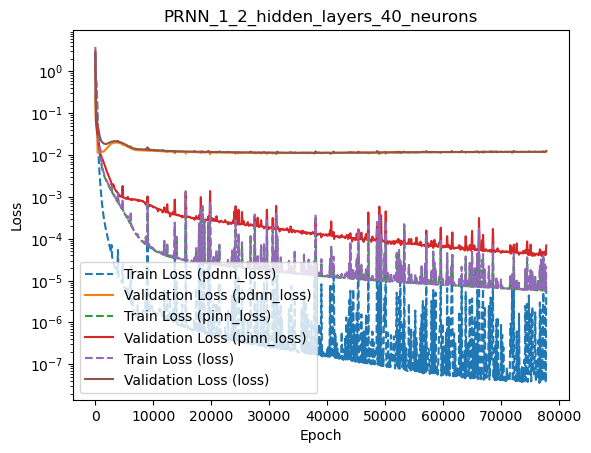

In [16]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [17]:
np.random.seed(0)

reduction_method.initialize_testing_set(100)
test_set_mu = torch.tensor(reduction_method.testing_set)
online_mu = tuple(np.array(reduction_method.testing_set)[0,:])

# test_set_mu = data.train_data_no_snaps
# online_mu = tuple(np.array(data.train_data_no_snaps[0,:]))

#### 4.6.2 PINN Error Analysis

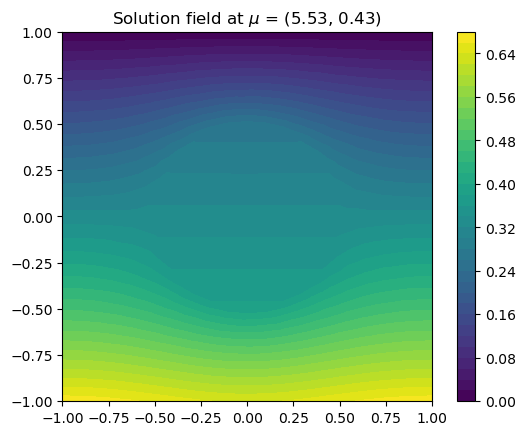

In [18]:
ErrorAnalysis.plot_solution(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn
)

In [19]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_set_mu, input_normalization_pinn, output_normalization_pinn
)

################################## PINN N = 4 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	4.6594083436344546e-05	4.6575845517672695e-05	4.5963247434574336e-07
mean	0.0043559406834421145	0.004355941586616587	6.332196261618342e-07
max	0.06117740099681985	0.061177414907474456	1.660229789911146e-06


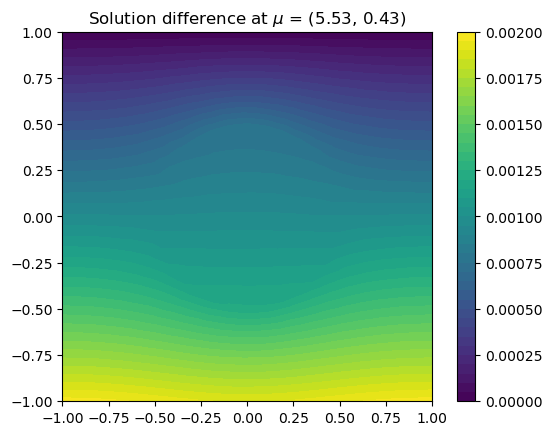

In [20]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn
)


#### 4.6.3 PDNN Error Analysis

In [21]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_set_mu, input_normalization_pdnn, output_normalization_pdnn
)

################################## PDNN N = 4 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	4.929830093578569e-07	9.705725236790384e-08	4.5963247434574336e-07
mean	0.48291165311170586	0.48291162592680864	6.332196261618342e-07
max	9.678678518350926	9.678678599038253	1.660229789911146e-06


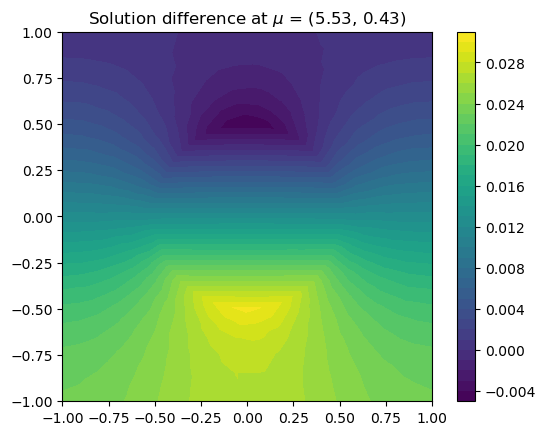

In [22]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, online_mu, input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [23]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_set_mu, input_normalization_prnn, output_normalization_prnn
)

################################# PRNN_1 N = 4 #################################
ERROR	NN-HF			NN-RO			RO-HF
min	9.796374516281528e-05	9.798103678267159e-05	4.5963247434574336e-07
mean	0.0066530293988610965	0.006653029516624724	6.332196261618342e-07
max	0.23601668939990617	0.23601670772372624	1.660229789911146e-06


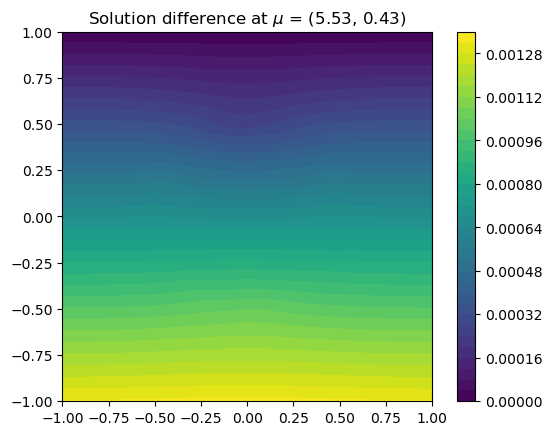

In [24]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, online_mu, input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [25]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_set_mu, input_normalizations, output_normalizations, euclidean=False
)

#####################################################################################
Mean Relative Error for N = 4 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	0.0043559406834421145	0.004355941586616587	6.332196261618342e-07
pdnn_net	0.48291165311170586	0.48291162592680864	6.332196261618342e-07
prnn_net	0.0066530293988610965	0.006653029516624724	6.332196261618342e-07
#####################################################################################


### 4.7. Perform a speedup analysis

In [26]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()
reduction_method.speedup_analysis()

=               ThermalBlock POD-Galerkin error analysis begins                =

###################################### 0 #######################################
###################################### 1 #######################################
###################################### 2 #######################################
###################################### 3 #######################################
###################################### 4 #######################################
###################################### 5 #######################################
###################################### 6 #######################################
###################################### 7 #######################################
###################################### 8 #######################################
###################################### 9 #######################################
###################################### 10 ######################################
###########################

###################################### 81 ######################################
###################################### 82 ######################################
###################################### 83 ######################################
###################################### 84 ######################################
###################################### 85 ######################################
###################################### 86 ######################################
###################################### 87 ######################################
###################################### 88 ######################################
###################################### 89 ######################################
###################################### 90 ######################################
###################################### 91 ######################################
###################################### 92 ######################################
############################